References:

- This is a follow-up of https://nbviewer.jupyter.org/github/mforets/escritoire/blob/master/2020/Week11/2D_intersection.ipynb
- Uses the concrete intersection of polygons in vertex representation implemented in https://github.com/JuliaReach/LazySets.jl/pull/2345

In [1]:
using LazySets, Plots, BenchmarkTools

In [25]:
function rectangular_overlap_exact_1(xmin, ymin, xmax, ymax, w, h, θ)
    sint, cost = sincos(deg2rad(θ))
    R = [cost -sint; sint cost]
    aper = R * Hyperrectangle(zeros(2), [w / 2, h / 2])
    dy = ymax - ymin
    dx = xmax - xmin
    pix = Hyperrectangle([dx / 2 + xmin, dy / 2 + ymin], [dx / 2, dy / 2])
    return intersection_area_1(pix, aper)
end

# contrib: https://nbviewer.jupyter.org/github/mforets/escritoire/blob/master/2020/Week11/2D_intersection.ipynb
# the idea is to use the intersection for HPolygon, which is faster than the fallback because the
# normal vectors to the half-spaces are sorted in counter--clockwise fashion
function intersection_area_1(X::AbstractHyperrectangle{N},
    Y::LinearMap{N,<:AbstractHyperrectangle{N}}) where {N}
    X_clist = X |> constraints_list
    X_poly = HPolygon(X_clist, sort_constraints = true, prune = false, check_boundedness = false)

    Y_clist = linear_map(matrix(Y), set(Y)) |> constraints_list
    Y_poly = HPolygon(Y_clist, sort_constraints = true, prune = false, check_boundedness = false)

    return intersection(X_poly, Y_poly) |> area
end

intersection_area_1 (generic function with 1 method)

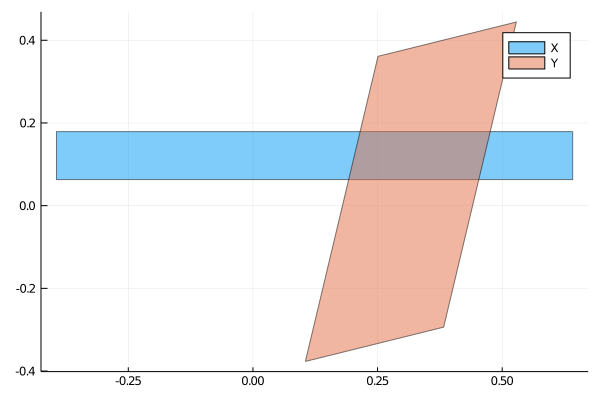

In [4]:
X = rand(Hyperrectangle)
Y = rand(2, 2) * rand(Hyperrectangle)

plot(X, lab="X")
plot!(Y, lab="Y")

In [5]:
using InteractiveUtils

In [21]:
@btime intersection_area_1($X, $Y)

  6.944 μs (139 allocations: 11.72 KiB)


0.030297577187546103

In [16]:
function rectangular_overlap_exact_2(xmin, ymin, xmax, ymax, w, h, θ)
    sint, cost = sincos(deg2rad(θ))
    R = [cost -sint; sint cost]
    aper = R * Hyperrectangle(zeros(2), [w / 2, h / 2])
    dy = ymax - ymin
    dx = xmax - xmin
    pix = Hyperrectangle([dx / 2 + xmin, dy / 2 + ymin], [dx / 2, dy / 2])
    return intersection_area_2(pix, aper)
end

function intersection_area_2(X::AbstractHyperrectangle{N},
                             Y::LinearMap{N, <:AbstractHyperrectangle{N}}) where {N}
    intersection(convert(VPolygon, X), convert(VPolygon, Y)) |> area
end

intersection_area_2 (generic function with 1 method)

In [15]:
@btime intersection_area_2($X, $Y)

  1.865 μs (52 allocations: 4.56 KiB)


0.030297577187546124

In [26]:
rectangular_overlap_exact_2(xmin, ymin, xmax, ymax, w, h, θ)

0.25

In [27]:
xmin, ymin, xmax, ymax, w, h, θ = (0, 0, 1, 1, 1, 1, 0)

(0, 0, 1, 1, 1, 1, 0)

In [28]:
rectangular_overlap_exact_1(xmin, ymin, xmax, ymax, w, h, θ)

0.25

In [29]:
@btime rectangular_overlap_exact_1($xmin, $ymin, $xmax, $ymax, $w, $h, $θ)
@btime rectangular_overlap_exact_2($xmin, $ymin, $xmax, $ymax, $w, $h, $θ)

  6.043 μs (129 allocations: 9.83 KiB)
  1.865 μs (54 allocations: 4.47 KiB)


0.25

In [45]:
function rectangular_overlap_exact_3(xmin, ymin, xmax, ymax, w, h, θ)
    sint, cost = sincos(deg2rad(θ))
    R = [cost -sint; sint cost]
    aper = R * Hyperrectangle(zeros(2), [w / 2, h / 2])
    dy = ymax - ymin
    dx = xmax - xmin
    pix = Hyperrectangle([dx / 2 + xmin, dy / 2 + ymin], [dx / 2, dy / 2], check_bounds=true)
    return intersection_area_3(pix, aper)
end

function intersection_area_3(X::AbstractHyperrectangle{N},
                             Y::LinearMap{N, <:AbstractHyperrectangle{N}}) where {N}
    p = convert(VPolygon, X)
    q = convert(VPolygon, Y)
    o = LazySets._intersection_vrep(p.vertices, q.vertices)
    return LazySets._area_polygon(convex_hull(o))
end

intersection_area_3 (generic function with 1 method)

In [46]:
@btime rectangular_overlap_exact_3($xmin, $ymin, $xmax, $ymax, $w, $h, $θ)

  1.859 μs (53 allocations: 4.45 KiB)


0.25

In [34]:
@code_warntype intersection_area_1(X, Y)

Variables
  #self#::Core.Compiler.Const(intersection_area_1, false)
  X::Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}
  Y::LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}
  X_clist::Array{HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}},1}
  X_poly::HPolygon{Float64,LazySets.Arrays.SingleEntryVector{Float64}}
  Y_clist::Array{HalfSpace{Float64,Array{Float64,1}},1}
  Y_poly::HPolygon{Float64,Array{Float64,1}}

Body::Any
1 ─       (X_clist = X |> Main.constraints_list)
│   %2  = (:sort_constraints, :prune, :check_boundedness)::Core.Compiler.Const((:sort_constraints, :prune, :check_boundedness), false)
│   %3  = Core.apply_type(Core.NamedTuple, %2)::Core.Compiler.Const(NamedTuple{(:sort_constraints, :prune, :check_boundedness),T} where T<:Tuple, false)
│   %4  = Core.tuple(true, false, false)::Core.Compiler.Const((true, false, false), false)
│   %5  = (%3)(%4)::NamedTuple{(:sort_constraints, :prune, :check_bou

In [36]:
@code_warntype intersection_area_2(X, Y)

Variables
  #self#::Core.Compiler.Const(intersection_area_2, false)
  X::Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}
  Y::LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}

Body::Float64
1 ─ %1 = Main.convert(Main.VPolygon, X)::VPolygon{Float64,Array{Float64,1}}
│   %2 = Main.convert(Main.VPolygon, Y)::VPolygon{Float64,Array{Float64,1}}
│   %3 = Main.intersection(%1, %2)::Union{EmptySet{Float64}, VPolygon{Float64,Array{Float64,1}}}
│   %4 = (%3 |> Main.area)::Float64
└──      return %4


In [44]:
@code_warntype intersection_area_3(X, Y)

Variables
  #self#::Core.Compiler.Const(intersection_area_3, false)
  X::Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}
  Y::LinearMap{Float64,Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,2}}
  p::VPolygon{Float64,Array{Float64,1}}
  q::VPolygon{Float64,Array{Float64,1}}
  o::Array{Array{Float64,1},1}

Body::Float64
1 ─      (p = Main.convert(Main.VPolygon, X))
│        (q = Main.convert(Main.VPolygon, Y))
│   %3 = LazySets._intersection_vrep::Core.Compiler.Const(LazySets._intersection_vrep, false)
│   %4 = Base.getproperty(p, :vertices)::Array{Array{Float64,1},1}
│   %5 = Base.getproperty(q, :vertices)::Array{Array{Float64,1},1}
│        (o = (%3)(%4, %5))
│   %7 = LazySets._area_polygon::Core.Compiler.Const(LazySets._area_polygon, false)
│   %8 = Main.convex_hull(o)::Array{Array{Float64,1},1}
│   %9 = (%7)(%8)::Float64
└──      return %9


---

## Using Static Arrays

In [47]:
using StaticArrays

In [129]:
function rectangular_overlap_exact_4(xmin, ymin, xmax, ymax, w, h, θ)
    sint, cost = sincos(deg2rad(θ))
    R = @SMatrix[cost -sint; sint cost]
    aper = R * Hyperrectangle(@SVector(zeros(2)), @SVector[w / 2, h / 2])
    dy = ymax - ymin
    dx = xmax - xmin
    pix = Hyperrectangle(@SVector[dx / 2 + xmin, dy / 2 + ymin], @SVector[dx / 2, dy / 2])
    return intersection_area_4(pix, aper)
end

function intersection_area_4(X::AbstractHyperrectangle{N},
                             Y::LinearMap{N, <:AbstractHyperrectangle{N}}) where {N}
    Xvert = vertices_list(X) # < 48ns
    p = VPolygon(Xvert)
    
    #Yvert = vertices_list(Y) # slow, requires fixing zonotope vertices list with sarray
    Yvert = vertices_list(linear_map(matrix(Y), convert(VPolygon, set(Y))))
    q = VPolygon(Yvert)
    #o = LazySets._intersection_vrep(Xvert, Yvert)

    #p = convert(VPolygon, X)
    #q = convert(VPolygon, Y)
    return area(intersection(p, q))
    
    #return LazySets._area_polygon(convex_hull(o))
end

intersection_area_4 (generic function with 1 method)

In [132]:
@btime rectangular_overlap_exact_3($xmin, $ymin, $xmax, $ymax, $w, $h, $θ)

# using static arrays
@btime rectangular_overlap_exact_4($xmin, $ymin, $xmax, $ymax, $w, $h, $θ)

  1.858 μs (53 allocations: 4.45 KiB)
  975.000 ns (29 allocations: 2.89 KiB)


0.25

In [107]:
A = SMatrix{2, 2}(rand(2, 2))
Y = rand(Hyperrectangle)
Ys = Hyperrectangle(SVector{2}(Y.center), SVector{2}(Y.radius))

Hyperrectangle{Float64,SArray{Tuple{2},Float64,1,2},SArray{Tuple{2},Float64,1,2}}([-0.7136783382212469, 0.5250164637359668], [0.8859445280609837, 0.3473398236459588])

In [113]:
Z = linear_map(A, Ys)

Zonotope{Float64,SArray{Tuple{2},Float64,1,2},Array{Float64,2}}([-0.04513490514715934, -0.1721485172584112], [0.6734657406820234 0.32905597183166246; 0.4876845489232684 0.14601636953147182])

In [116]:
vertices_list(Z) # we loose SArrays

4-element Array{Array{Float64,1},1}:
 [-1.047656617660845, -0.8058494357131514]
 [0.29927486370320155, 0.1695196621333854]
 [-0.38954467399752024, -0.5138166966502078]
 [0.9573868073665265, 0.461552401196329]

In [120]:
vertices_list(linear_map(A, convert(VPolygon, Ys)))

4-element Array{SArray{Tuple{2},Float64,1,2},1}:
 [0.9573868073665264, 0.461552401196329]
 [0.29927486370320155, 0.16951966213338537]
 [-1.047656617660845, -0.8058494357131514]
 [-0.38954467399752024, -0.5138166966502077]

## Vertices list for hyperrectangular sets

In [60]:
function _vertices_list(H::AbstractHyperrectangle{N}) where {N<:Real}
    n = dim(H)

    # identify flat dimensions and store them in a binary vector whose entry in
    # dimension i is 0 if the radius is zero and 1 otherwise
    # the vector will later also contain entries -1
    trivector = Vector{Int8}(undef, n)
    m = 1
    c = center(H)
    v = copy(c)
    @inbounds for i in 1:n
        ri = radius_hyperrectangle(H, i)
        if iszero(ri)
            trivector[i] = Int8(0)
        else
            v[i] += ri
            trivector[i] = Int8(1)
            m *= 2
        end
    end

    # create vertices by modifying the three-valued vector and constructing the
    # corresponding point; for efficiency, we create a copy of the old point and
    # modify every entry that has changed in the three-valued vector
    vlist = Vector{Vector{N}}(undef, m)
    vlist[1] = copy(v)
    @inbounds for i in 2:m
        for j in 1:length(v)
            if trivector[j] == Int8(-1)
                trivector[j] = Int8(1)
                v[j] = c[j] + radius_hyperrectangle(H, j)
            elseif trivector[j] == Int8(1)
                trivector[j] = Int8(-1)
                v[j] = c[j] - radius_hyperrectangle(H, j)
                break
            end
        end
        vlist[i] = copy(v)
    end
    return vlist
end

_vertices_list (generic function with 1 method)

In [61]:
p = Iterators.product(@SVector[1, -1], @SVector[1, -1])

Base.Iterators.ProductIterator{Tuple{SArray{Tuple{2},Int64,1,2},SArray{Tuple{2},Int64,1,2}}}(([1, -1], [1, -1]))

In [95]:
function LazySets.vertices_list(H::Hyperrectangle{N, <:SVector, <:SVector}) where {N}
    n = dim(H)
    if n == 2
        return [H.center + @SVector[1, 1] .* H.radius,
                H.center + @SVector[1, -1] .* H.radius,
                H.center + @SVector[-1, 1] .* H.radius,
                H.center + @SVector[-1, -1] .* H.radius]
    else
        p = Iterators.product(fill(@SVector[1, -1], n)...)
        return collect(Iterators.map(x -> H.center .* x + H.radius, p))[:]
    end
end

In [96]:
H = rand(Hyperrectangle)
@btime vertices_list($H)

  185.052 ns (7 allocations: 688 bytes)


4-element Array{Array{Float64,1},1}:
 [2.934223799034668, 0.5753980046428175]
 [-1.6874171194837804, 0.5753980046428175]
 [2.934223799034668, -1.7721897479794784]
 [-1.6874171194837804, -1.7721897479794784]

In [97]:
Hs = Hyperrectangle(SVector{2}(H.center), SVector{2}(H.radius))

Hyperrectangle{Float64,SArray{Tuple{2},Float64,1,2},SArray{Tuple{2},Float64,1,2}}([0.6234033397754437, -0.5983958716683304], [2.310820459259224, 1.173793876311148])

In [98]:
@btime vertices_list($Hs)

  24.909 ns (1 allocation: 144 bytes)


4-element Array{SArray{Tuple{2},Float64,1,2},1}:
 [2.934223799034668, 0.5753980046428175]
 [2.934223799034668, -1.7721897479794784]
 [-1.6874171194837804, 0.5753980046428175]
 [-1.6874171194837804, -1.7721897479794784]

In [ ]:
julia> p = Iterators.product(fill([1, -1], 2)...)
Base.Iterators.ProductIterator{Tuple{Vector{Int64},Vector{Int64}}}(([1, -1], [1, -1]))

julia> Iterators.map(x -> rand(2) .* x .+ rand(2), p)
Base.Generator{Base.Iterators.ProductIterator{Tuple{Vector{Int64},Vector{Int64}}},var"#27#28"}(var"#27#28"(), Base.Iterators.ProductIterator{Tuple{Vector{Int64},Vector{Int64}}}(([1, -1], [1, -1])))

julia> first(ans)
2-element Vector{Float64}:
 1.0472048628849284
 1.9230998571087827